In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
%run simple_thermalblock_swipdg_example.ipynb

In [3]:
disc = discretize(18)
disc.disable_logging()

num_f_evals = 0

def f(mu):
    global num_f_evals
    num_f_evals += 1
    return disc.rhs.apply(disc.solve(mu)).data[0]

points = [(0.1, 0.1),]

<IPython.core.display.Javascript object>


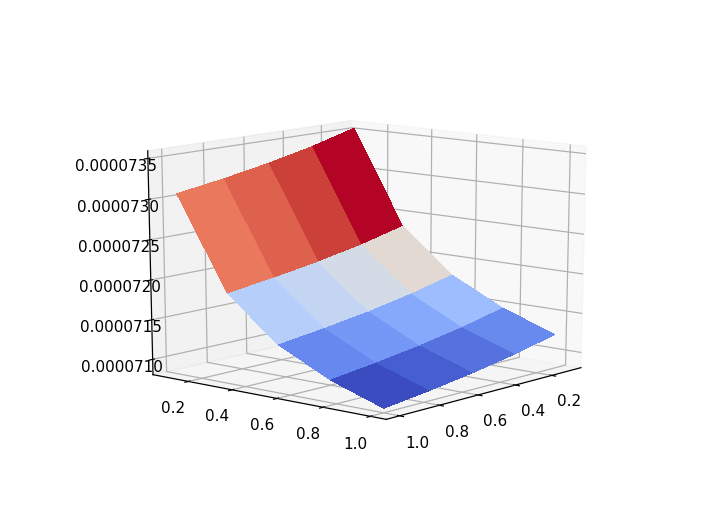

In [8]:
N = 5
X = np.linspace(0.1, 1., N)
Y = np.linspace(0.1, 1., N)

Z = np.zeros((N, N))
for ii in range(N):
    for jj in range(N):
        Z[ii][jj] = f((X[ii], Y[jj]))
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

minimizing ... finished!
  x_min:    [ 1.  1.]
  f(x_min): [  7.08608305e-05]
  num iterations:     7
  num function calls: 147


<IPython.core.display.Javascript object>


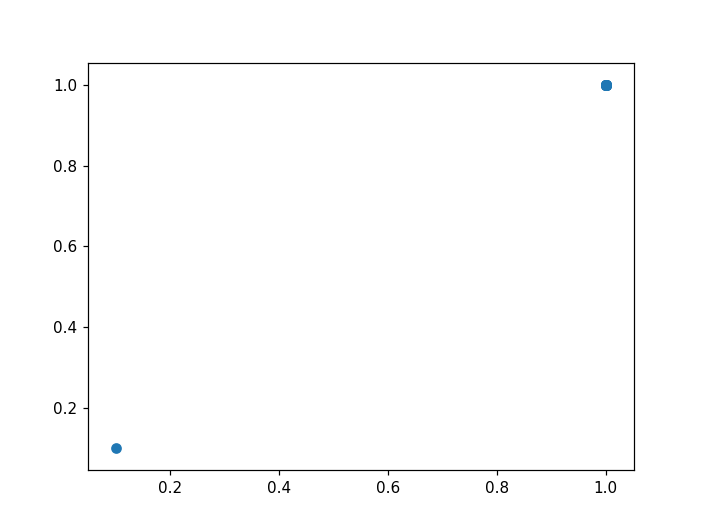

In [9]:
from scipy.optimize import minimize

print('minimizing ... ', end='')

result = minimize(f, points[0], method='L-BFGS-B', jac=False,
                  bounds=((0.1, 1), (0.1, 1)),
                  callback=lambda xk: points.append(xk),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

if (result.status != 0):
    print('failed!')
else:
    print('finished!')
    print('  x_min:    {}'.format(result.x))
    print('  f(x_min): {}'.format(result.fun))
    print('  num iterations:     {}'.format(result.nit))
    print('  num function calls: {}'.format(num_f_evals))
    
    plt.scatter(np.array([p[0] for p in points]),
                np.array([p[1] for p in points]))
    plt.show()